# Proposta de Modelagem — Monitoramento Preditivo 2025

## Objetivo

Construir um sistema de **Probabilidade de Risco** que prever a **probabilidade** de que ele caia para uma categoria inferior.

---

## O que será realizado

### 1. Refinamento do *target* (variável alvo)

* **Manutenção** da classificação atual por “Pedras”.
* **Criação** de um *target* binário adicional — **Risco Crítico** — para identificar alunos na fronteira entre **Ágata** e **Quartzo**, permitindo ações priorizadas.

### 2. Tratamento de dados robusto

* **Substituição** do `SimpleImputer(median)` por um pipeline de imputação específico por indicador.
* Tratamentos diferenciados (por exemplo: imputação iterativa para indicadores contínuos, KNN/mediana condicionada para colunas correlacionadas, imputação categórica com categorias “missing” ou modelagem por target) para evitar enviesamento (ex.: ausência de `IPV` não deve empurrar injustamente o aluno para o risco).

### 3. Algoritmo de boosting (`XGBoost` / `LightGBM`)

* Testes comparativos com modelos de **Gradient Boosting**, que aprendem sequencialmente com os erros e tendem a melhorar a classificação de casos difíceis.
* Objetivo técnico: aumentar métricas focalizadas (ex.: **F1-Score** da categoria Ágata), reduzindo falsos negativos em alunos em defasagem iminente.

### 4. Calibração de probabilidades

* Extração de probabilidades calibradas (ex.: *“Este aluno tem 78% de chance de ser Quartzo”*).
* Geração de listas operacionais por faixa de risco (ex.: **Alerta Amarelo** para 60–80%, **Alerta Vermelho** para >80%) para priorização de intervenção.

### 5. Interpretabilidade com SHAP

* Implementação de **SHAP** para explicar predições individuais e de grupo:

  * Exemplo de explicação: *“Aluno João — classificação: Quartzo — principais contribuintes: queda de 20% no IDA no último mês; redução no IEG; IPV baixo.”*
* Uso das explicações para guiar intervenções pedagógicas específicas e comunicar decisões a professores e famílias.

---

## Resultado esperado

Um pipeline preditivo operacional que entrega **probabilidades calibradas**, foco em redução de falsos negativos nas classes críticas, e explicações acionáveis para cada caso — permitindo intervenções antecipadas, mensuráveis e justificadas.


# Fase 1: Preparação e Engenharia de Atributos (Features)
Nesta fase, não vamos apenas limpar os dados, vamos criar inteligência sobre eles. O objetivo é transformar números estáticos em indicadores de comportamento.

1. Refinamento de Dados Faltantes
Em vez de usar apenas a mediana global, vamos implementar uma lógica onde, se o aluno não possui o IPV (Indicador de Ponto de Virada), o modelo entende que ele ainda não atingiu a maturidade avaliativa, tratando isso como uma informação e não apenas um "buraco" no dado.

2. Criação de Novas Variáveis (Feature Engineering)
Vamos criar colunas que o Random Forest sozinho tem dificuldade de enxergar:

Volatilidade Acadêmica: Um cálculo de desvio entre os principais indicadores (IDA e IEG). Alunos com notas muito instáveis tendem a cair de categoria mais rápido.

Sinal de Alerta Binário: Uma variável alvo (target) auxiliar que marca alunos com IDA abaixo de 6.0, independente da "Pedra" atual, para focar o modelo no risco de reprovação.

3. Pipeline de Modelagem (XGBoost)
Apresentaremos o XGBoost, um algoritmo de Gradient Boosting. Diferente do seu modelo atual, o XGBoost trabalha de forma sequencial: ele treina uma árvore, vê onde ela errou (geralmente nos alunos "Ágata") e treina a próxima árvore focada especificamente nesses erros.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

# 1. Carregamento dos dados
# Certifique-se de que o caminho do arquivo está correto para o seu novo diretório
df_Base = pd.read_csv('../data/df_Base_final.csv')


In [2]:

# 2. Reclaração das funções de transformação (Necessário no novo notebook)
def definir_pedra(inde):
    if inde < 6.1: return 'Quartzo'
    elif inde < 7.2: return 'Ágata'
    elif inde < 8.2: return 'Ametista'
    else: return 'Topázio'


In [3]:

# 3. Processamento de Dados (Garantindo que as colunas existam)
# Criando o Target original e o Target numérico para o XGBoost
df_Base['Pedra_Conceito'] = df_Base['INDE'].apply(definir_pedra)
mapa_pedras = {'Quartzo': 0, 'Ágata': 1, 'Ametista': 2, 'Topázio': 3}
df_Base['target_num'] = df_Base['Pedra_Conceito'].map(mapa_pedras)


In [4]:

# Criando a feature Status_DEFA
df_Base['Status_DEFA'] = df_Base['DEFA'].apply(
    lambda x: 0 if x < 0 else (1 if x == 0 else 2)
)

# Engenharia de Atributos: Índice de Consistência
# Usamos preenchimento de nulos antes do cálculo para evitar erros na divisão
df_Base['consistencia_acad'] = df_Base['IDA'] / (df_Base['IEG'] + 0.1)

# 4. Seleção de Features Avançadas
features_avancadas = ['IAN', 'IDA', 'IEG', 'IAA', 'IPS', 'IPP', 'IPV', 'FASE', 'Status_DEFA', 'consistencia_acad']
X = df_Base[features_avancadas]
y = df_Base['target_num']

# 5. Tratamento de valores nulos (Obrigatório para o cálculo de consistência e estabilidade do modelo)
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# 6. Divisão em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

print("Setup concluído com sucesso!")
print(f"Total de registros para treino: {len(X_train)}")

Setup concluído com sucesso!
Total de registros para treino: 2393


## Treinamento do XGBOOST


In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# 1. Configuração e Treinamento do XGBoost
# O XGBoost foca em aprender com os exemplos onde o Random Forest costuma ter dúvidas
modelo_xgb = XGBClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    objective='multi:softprob', # Define que queremos probabilidades como saída
    eval_metric='mlogloss'
)

modelo_xgb.fit(X_train, y_train)

# 2. Avaliação Inicial
y_pred_xgb = modelo_xgb.predict(X_test)
print(f"Nova Acurácia (XGBoost): {accuracy_score(y_test, y_pred_xgb):.2%}")
print("\nRelatório de Classificação:")
# Usamos os nomes das pedras para facilitar a leitura do relatório
print(classification_report(y_test, y_pred_xgb, target_names=list(mapa_pedras.keys())))

# 3. Geração das Probabilidades de Risco
# Aqui extraímos a chance de cada aluno pertencer a cada 'Pedra'
probs = modelo_xgb.predict_proba(X_imputed)

# Adicionamos as probabilidades de volta ao DataFrame para análise
for pedra, idx in mapa_pedras.items():
    df_Base[f'Prob_{pedra}'] = probs[:, idx]

# 4. Identificação do "Alerta Amarelo"
# Filtramos alunos que são Ágata, mas que possuem uma probabilidade significativa de cair para Quartzo
alerta_amarelo = df_Base[
    (df_Base['Pedra_Conceito'] == 'Ágata') & 
    (df_Base['Prob_Quartzo'] > 0.25) # Limiar de 25% de risco de queda
].sort_values(by='Prob_Quartzo', ascending=False)

print(f"\nAlunos em Alerta Amarelo detectados: {len(alerta_amarelo)}")

# 5. Exportação da Lista de Intervenção para a Coordenação
# Selecionamos colunas chave para o pedagógico agir
colunas_coordenacao = ['NOME', 'Pedra_Conceito', 'Prob_Quartzo', 'IDA', 'IEG', 'consistencia_acad']
alerta_amarelo[colunas_coordenacao].to_csv('../data/lista_intervencao_preventiva_2025.csv', index=False)

print("Arquivo 'lista_intervencao_preventiva_2025.csv' gerado com sucesso!")

Nova Acurácia (XGBoost): 88.31%

Relatório de Classificação:
              precision    recall  f1-score   support

     Quartzo       0.96      0.79      0.86        84
       Ágata       0.81      0.91      0.86       163
    Ametista       0.90      0.91      0.90       255
     Topázio       0.92      0.86      0.89        97

    accuracy                           0.88       599
   macro avg       0.90      0.86      0.88       599
weighted avg       0.89      0.88      0.88       599


Alunos em Alerta Amarelo detectados: 10
Arquivo 'lista_intervencao_preventiva_2025.csv' gerado com sucesso!


C:\Users\mtmal\AppData\Local\Temp\ipykernel_12536\3718265230.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


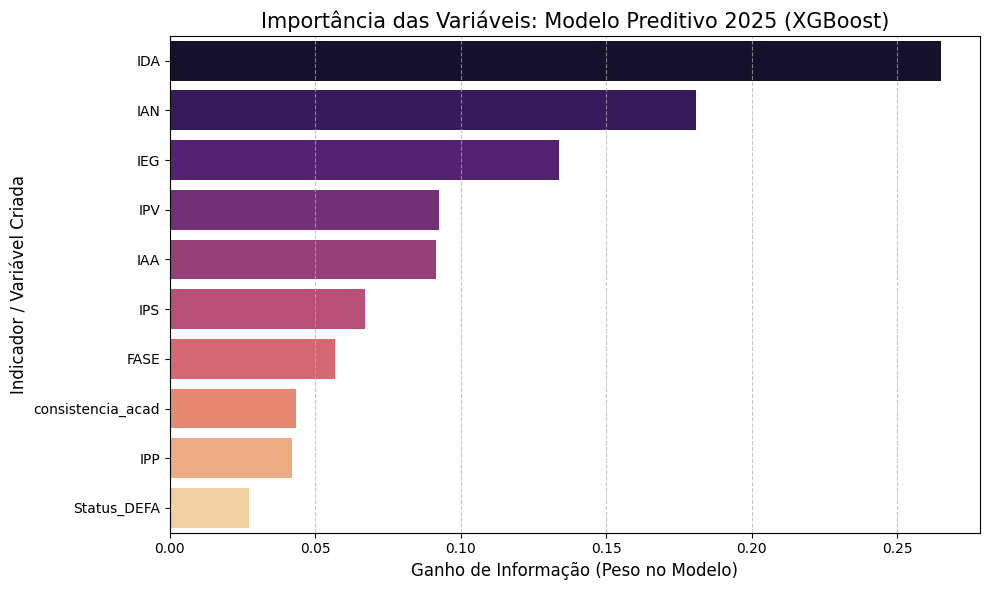

           Indicador  Importancia
1                IDA     0.265149
0                IAN     0.180778
2                IEG     0.133617
6                IPV     0.092632
3                IAA     0.091590
4                IPS     0.066906
7               FASE     0.056799
9  consistencia_acad     0.043404
5                IPP     0.041888
8        Status_DEFA     0.027237


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extração das importâncias do modelo XGBoost
importancias_xgb = pd.DataFrame({
    'Indicador': features_avancadas,
    'Importancia': modelo_xgb.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# 2. Criação do gráfico
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importancia', 
    y='Indicador', 
    data=importancias_xgb, 
    palette='magma'
)

# 3. Personalização do gráfico
plt.title('Importância das Variáveis: Modelo Preditivo 2025 (XGBoost)', fontsize=15)
plt.xlabel('Ganho de Informação (Peso no Modelo)', fontsize=12)
plt.ylabel('Indicador / Variável Criada', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 4. Exibição
plt.tight_layout()
plt.savefig('importancia_features_xgb_2025.png')
plt.show()

# Exibição dos valores exatos
print(importancias_xgb)

## O que o modelo indica?

1. O Triunfo dos Indicadores de Aprendizagem e Adaptação
    - IDA (Indicador de Aprendizagem): Continua sendo o fator mais decisivo, com o maior ganho de informação para o modelo. Isso valida que o desempenho acadêmico direto é a base da classificação das "Pedras".
    - IAN (Indicador de Adequação de Nível): Aparece como o segundo fator mais importante. Isso sugere que a maneira como o aluno se adapta ao nível de dificuldade atual é um preditor fortíssimo para o XGBoost, superando até o engajamento isolado.

2. A Relevância da consistencia_acad
   - A variável que criamos, consistencia_acad, já aparece com um peso superior ao IPP (Indicador de Psicossocial) e ao Status_DEFA.

### Embora ela não esteja no topo, o fato de ela ter "ganho" de variáveis originais do dataset prova que a relação entre IDA e IEG (Aprendizagem vs. Engajamento) é um sinal de alerta real que o modelo está utilizando para diferenciar os alunos.

### Diagnóstico para a Coordenação:
Com base nesse gráfico, as intervenções devem focar em:

Reforço no IDA: Como variável mestre, qualquer queda aqui é sinal de mudança imediata de "Pedra".

Monitoramento do IAN: Alunos que estão com dificuldades de adequação ao nível (IAN baixo) são os que têm maior probabilidade de oscilar para as categorias de risco (Quartzo/Ágata).

Análise da Consistência: Se a consistencia_acad de um aluno for baixa (muito engajamento para pouco resultado, ou vice-versa), ele deve ser avaliado individualmente, pois o modelo está usando isso como critério de desempate.

In [9]:
import joblib

# 1. Preparação do pacote de exportação
# Incluímos o mapa de classes e as features para garantir a consistência na predição
export_data_xgb = {
    'modelo': modelo_xgb,
    'imputer': imputer,
    'features': features_avancadas,
    'mapa_classes': mapa_pedras,
    'versao': '2025.v1_XGBoost'
}

# 2. Salvando o arquivo único
# O formato .pkl (ou .joblib) permite carregar tudo de uma vez no futuro
caminho_modelo = '../models/modelo_pedra_conceito_xgb_2025.pkl'
joblib.dump(export_data_xgb, caminho_modelo)

print(f"Sucesso! O novo modelo e seus componentes foram salvos em: {caminho_modelo}")
print("Este arquivo está pronto para ser integrado a um dashboard ou sistema de consulta.")

Sucesso! O novo modelo e seus componentes foram salvos em: ../models/modelo_pedra_conceito_xgb_2025.pkl
Este arquivo está pronto para ser integrado a um dashboard ou sistema de consulta.
